# Demonstration of `pdfplumber`'s table-extraction options

This notebook uses a [report from the FBI's National Instant Criminal Background Check System](../pdfs/background-checks.pdf).

### Import `pdfplumber`

In [1]:
import pdfplumber

### Load the PDF

In [2]:
pdf = pdfplumber.open("../pdfs/background-checks.pdf")

### Get the first page

In [3]:
p0 = pdf.pages[0]

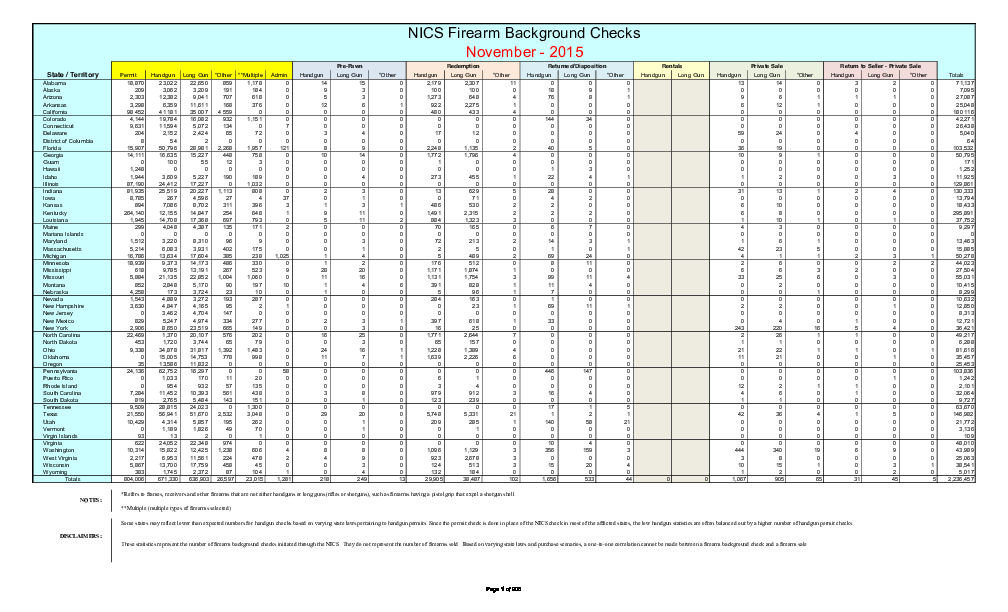

In [4]:
im = p0.to_image()
im

### What data would we get if we used the default settings?

We can check by using `PageImage.debug_tablefinder()`:

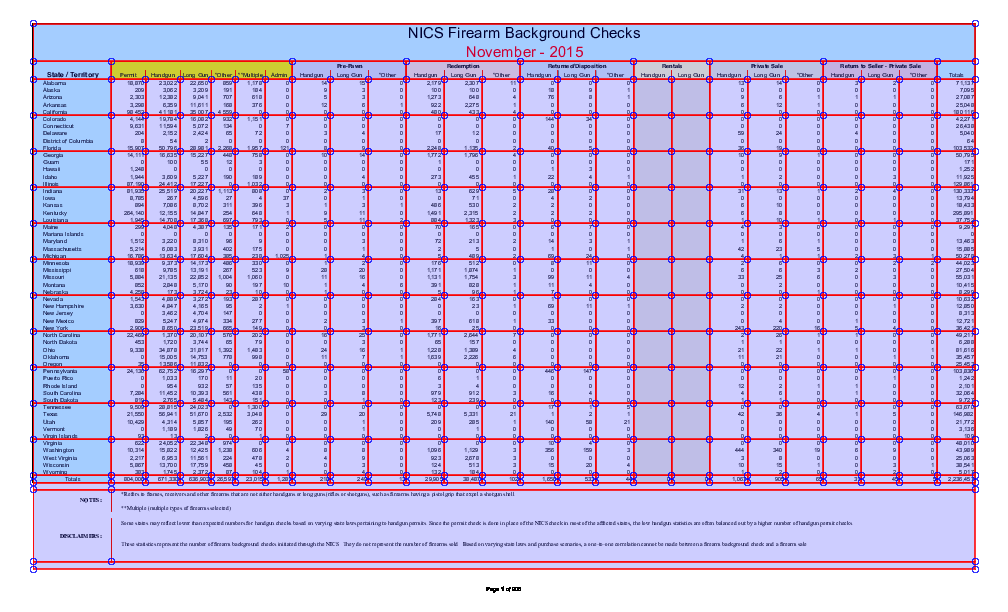

In [5]:
im.reset().debug_tablefinder()

The default settings correctly identify the table's vertical demarcations, but don't capture the horizontal demarcations between each group of five states/territories. So:

### Using custom `.extract_table`'s settings

- Because the columns are separated by lines, we use `vertical_strategy="lines"`
- Because the rows are, primarily, separated by gutters between the text, we use `horizontal_strategy="text"`
- And because the left and right-hand extremities of the text aren't quite flush with the vertical lines, we use `"intersection_tolerance": 15`

In [6]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "text",
    "intersection_x_tolerance": 15
}

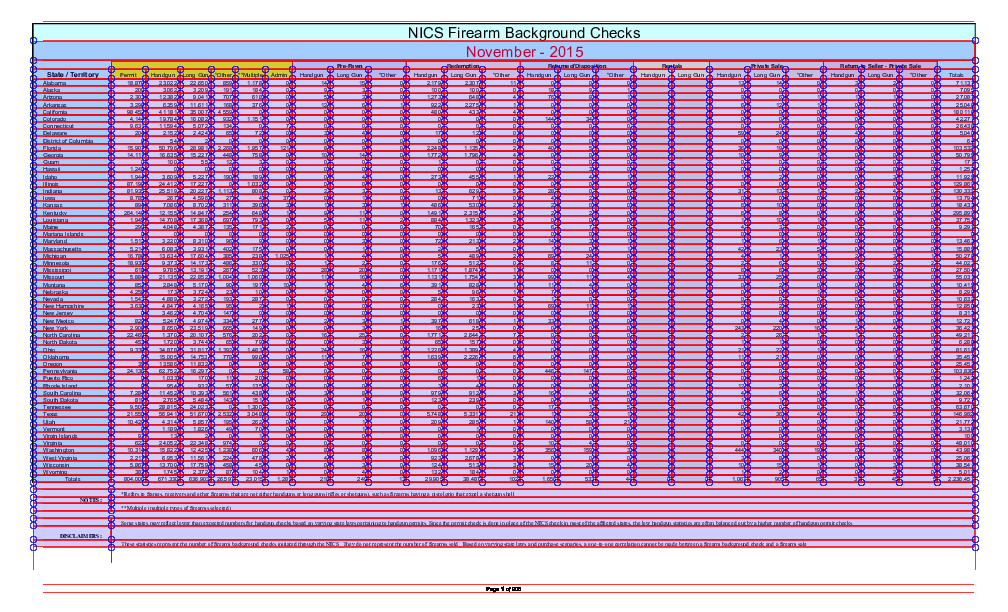

In [7]:
im.reset().debug_tablefinder(table_settings)

In [8]:
table = p0.extract_table(table_settings)

In [9]:
for row in table[:5]:
    print(row)

['November - 2015', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
['Pre-Pawn Redemption Returned/Disposition Rentals Private Sale Return to Seller - Private Sale', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
['State / Territory', 'Permit', 'Handgun', 'Long Gun', '*Other', '**Multiple', 'Admin', 'Handgun', 'Long Gun', '*Other', 'Handgun', 'Long Gun', '*Other', 'Handgun', 'Long Gun', '*Other', 'Handgun', 'Long Gun', 'Handgun', 'Long Gun', '*Other', 'Handgun', 'Long Gun', '*Other', 'Totals']
['Alabama', '18,870', '23,022', '22,650', '859', '1,178', '0', '14', '15', '0', '2,179', '2,307', '11', '0', '0', '0', '', '', '13', '14', '0', '3', '2', '0', '71,137']
['Alaska', '209', '3,062', '3,209', '191', '184', '0', '9', '3', '0', '100', '100', '0', '18', '9', '1', '', '', '0', '0', '0', '0', '0', '

### Cleaning up the data

`.extract_table` worked with our custom settings, but the table it detected contains extraneous headers and footers. Since we know that the `Alabama` row is the first, and that there are 56 rows we care about (50 states + DC + 4 territories + the "Totals" row), we can slice away the rest:

In [10]:
core_table = table[3:3+56]

The first row:

In [11]:
" • ".join(core_table[0])

'Alabama • 18,870 • 23,022 • 22,650 • 859 • 1,178 • 0 • 14 • 15 • 0 • 2,179 • 2,307 • 11 • 0 • 0 • 0 •  •  • 13 • 14 • 0 • 3 • 2 • 0 • 71,137'

The last:

In [12]:
" • ".join(core_table[-1])

'Totals • 804,006 • 671,330 • 636,903 • 26,597 • 23,015 • 1,281 • 218 • 249 • 13 • 29,905 • 38,487 • 102 • 1,656 • 533 • 44 • 0 • 0 • 1,067 • 905 • 65 • 31 • 45 • 5 • 2,236,457'

Now, let's turn those rows into dictionaries, and also convert strings-representing-numbers to the numbers themselves, e.g., `"18,870" -> 18870`:

In [13]:
COLUMNS = [
    "state",
    "permit",
    "handgun",
    "long_gun",
    "other",
    "multiple",
    "admin",
    "prepawn_handgun",
    "prepawn_long_gun",
    "prepawn_other",
    "redemption_handgun",
    "redemption_long_gun",
    "redemption_other",
    "returned_handgun",
    "returned_long_gun",
    "returned_other",
    "rentals_handgun",
    "rentals_long_gun",
    "private_sale_handgun",
    "private_sale_long_gun",
    "private_sale_other",
    "return_to_seller_handgun",
    "return_to_seller_long_gun",
    "return_to_seller_other",
    "totals"
]

In [14]:
def parse_value(i, x):
    if i == 0: return x
    if x == "": return None
    return int(x.replace(",", ""))

In [15]:
from collections import OrderedDict
def parse_row(row):
    return OrderedDict((COLUMNS[i], parse_value(i, cell))
        for i, cell in enumerate(row))

In [16]:
data = [ parse_row(row) for row in core_table ]

Now here's the first row, parsed:

In [17]:
data[0]

OrderedDict([('state', 'Alabama'),
             ('permit', 18870),
             ('handgun', 23022),
             ('long_gun', 22650),
             ('other', 859),
             ('multiple', 1178),
             ('admin', 0),
             ('prepawn_handgun', 14),
             ('prepawn_long_gun', 15),
             ('prepawn_other', 0),
             ('redemption_handgun', 2179),
             ('redemption_long_gun', 2307),
             ('redemption_other', 11),
             ('returned_handgun', 0),
             ('returned_long_gun', 0),
             ('returned_other', 0),
             ('rentals_handgun', None),
             ('rentals_long_gun', None),
             ('private_sale_handgun', 13),
             ('private_sale_long_gun', 14),
             ('private_sale_other', 0),
             ('return_to_seller_handgun', 3),
             ('return_to_seller_long_gun', 2),
             ('return_to_seller_other', 0),
             ('totals', 71137)])

### Sort the data

For demonstration purposes, let's list the rows with the highest number of handgun-only background checks:

In [18]:
for row in list(reversed(sorted(data, key=lambda x: x["handgun"])))[:6]:
    print("{state}: {handgun:,d} handgun-only checks".format(**row))

Totals: 671,330 handgun-only checks
Pennsylvania: 62,752 handgun-only checks
Texas: 56,941 handgun-only checks
Florida: 50,796 handgun-only checks
California: 41,181 handgun-only checks
Ohio: 34,878 handgun-only checks


### Use `extract_text` to extract the report month

It looks like the month of the report is listed in an area 35px to 65px from the top of the page. But there's also some other text directly above and below it. So when we crop for that area, we'll use `.within_bbox` instead of `.crop` to select only characters (and other objects) that are fully within the bounding box.

In [19]:
month_crop = p0.within_bbox((0, 35, p0.width, 65))
month_crop.to_image()

In [20]:
month_chars = month_crop.extract_text()
month_chars

'November - 2015'

---

---

---